In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

text_df = pd.read_pickle("datasets/text_dataset.pickle")
text_df.dropna(inplace=True)
text_df['text1'] = text_df['task1_text'].apply(lambda x: x.split(" "))
text_df['text2'] = text_df['task2_text'].apply(lambda x: x.split(" "))
text_df['text3'] = text_df['task3_text'].apply(lambda x: x.split(" "))

In [3]:
score_df = pd.read_pickle("datasets/score_dataset.pickle")
df = pd.merge(text_df, score_df, on='email')

In [4]:
from nltk.lm import NgramCounter
from nltk.util import ngrams
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE

def texts_bigram_probabilities(texts):
    train, vocab = padded_everygram_pipeline(2, texts)
    lm = MLE(2)
    lm.fit(train, vocab)
    
    scores = []
    for text in texts:
        text = ['<s>'] + text + ['</s>']
        score = 0
        for word1, word2 in zip(text[:-1], text[1:]):
            score += lm.logscore(word2, [word1])
        score /= len(text)
        scores.append(score)
        
    return scores


df['2gram_score1'] = texts_bigram_probabilities(df['text1'])
df['2gram_score2'] = texts_bigram_probabilities(df['text2'])
df['2gram_score3'] = texts_bigram_probabilities(df['text3'])
df['2gram_score']  = text_df[['2gram_score1', '2gram_score2', '2gram_score3']].aggregate(np.sum, axis=1)

KeyError: "None of [Index(['2gram_score1', '2gram_score2', '2gram_score3'], dtype='object')] are in the [columns]"

In [5]:
def texts_bigram_probabilities(texts):
    train, vocab = padded_everygram_pipeline(2, texts)
    lm = MLE(2)
    lm.fit(train, vocab)
    
    scores = []
    for text in texts:
        text = ['<s>'] + text + ['</s>']
        score = 0
        for word in text:
            score += lm.logscore(word)
        score /= len(text)
        scores.append(score)
        
    return scores


df['1gram_score1'] = texts_bigram_probabilities(df['text1'])
df['1gram_score2'] = texts_bigram_probabilities(df['text2'])
df['1gram_score3'] = texts_bigram_probabilities(df['text3'])
df['1gram_score']  = text_df[['1gram_score1', '1gram_score2', '1gram_score3']].aggregate(np.sum, axis=1)

KeyError: "None of [Index(['1gram_score1', '1gram_score2', '1gram_score3'], dtype='object')] are in the [columns]"

In [22]:
df.columns

Index(['email', 'task1_text', 'task2_text', 'task3_text', 'text1', 'text2',
       'text3', 'проактивность, инновативность', 'готовность к изменениям',
       'Коммуникация', 'Тиминг и командное взаимодействие', 'Работа с будущим',
       'Практики мышления', 'Креативность и работа с неопределенностью',
       'Управление ресурсными состояниями',
       'Самоорганизация и самоактуализация', 'Кросскультурность', 'Лидерство',
       'Цифровые образовательные технологии', 'Дизайн образования',
       'Онлайн и смешанное обучение',
       'Диагностика и оценка качества образования',
       'Деятельностная педагогика', 'Персонализация и непрерывное развитие',
       'Создание IT-продукта', 'Кибер и Инфо безопасность',
       'Цифровой дизайн и моделирование', 'Работа с данными',
       'Автоматизированные и автоматические вычисления', 'AV/VR',
       'Нейротехнологии', 'ИИ и интеллектуальный анализ данных',
       'Работа с большими данными', 'Сенсорика и робототехника',
       'Управление 

In [52]:
from collections import Counter

wf = Counter()
tf = dict()
idf = Counter()

for email, text1, text2, text3 in zip(df['email'], df['text1'], df['text2'], df['text3']):
    counter = Counter()
    text = text1 + text2 + text3
    for token in text:
        counter[token] += 1
        wf[token] += 1
    for token in counter:
        idf[token] += 1
    tf[email] = counter

    
tf_idf = dict()
for email, user_tf in tf.items():
    user_tf_idf = Counter()
    for token, value in user_tf.items():
        user_tf_idf[token] = value / idf[token]
    tf_idf[email] = user_tf_idf
    
unique_score = dict()
for email, user_tf in tf.items():
    user_corr = 0
    user_tf_idf = tf_idf[email]
    norm_koef = 0
    for token in wf.keys():
        user_corr += user_tf_idf[token]
    unique_score[email] = user_corr
    
df['tfidf_score'] = unique_score.values()

In [58]:
for email, val in unique_score.items():
    df.loc['tfidf_score', email] = val

In [65]:
unique_score['konkursfmnospu@yandex.ru']

16.043316873569676

In [68]:
df.loc['tfidf_score', 'konkursfmnospu@yandex.ru']

16.043316873569676

In [69]:
sorted_df = df.sort_values('2gram_score')

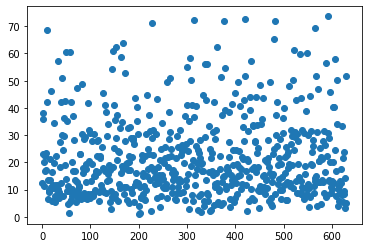

In [70]:
plt.scatter(range(len(sorted_df)), sorted_df['tfidf_score'].values)

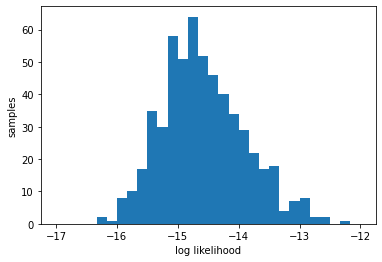

In [83]:
plt.hist(df['2gram_score'], range=(-17, -12), bins=30)
plt.xlabel("log likelihood")
plt.ylabel("samples")
plt.show()